## Setup

### Imports

In [32]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import torchvision.transforms as transforms
from torchvision.transforms import (
    Resize,
    RandomHorizontalFlip,
    ToTensor,
    Normalize
)
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import kagglehub
import os
from pathlib import Path
from PIL import Image
import numpy as np


### Dataset collection

In [ ]:
# Download latest version
TASK_NAME = 'Osteoporosis Knee X-ray'
path = kagglehub.dataset_download("mohamedgobara/osteoporosis-database")

path = os.path.join(path, TASK_NAME)
print("Path to dataset files:", path)


## Global variables

In [34]:
BATCH_SIZE = 8 
NUM_WORKERS = 2
IMG_SIZE = (224, 224)
NUM_CLASSES = 3
MAX_EPOCHS = 50
LEARNING_RATE = 0.001
CLASS_NAMES = ['normal', 'osteopenia', 'osteoporosis'] 

## Dataset

In [35]:
class OsteoporosisDataset(Dataset):
    """Custom dataset for Osteoporosis Classification"""

    def __init__(self, dataframe: pd.DataFrame, transform = None):
        # super().__init__()
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
        self.label_map = {label: key for key, label in enumerate(CLASS_NAMES)}
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx) -> list[Image.Image, int]:
        img_path = self.dataframe.iloc[idx]['filepaths']
        label    = self.dataframe.iloc[idx]['labels']
        label    = self.label_map[label]

        try:
            # Load image
            image = Image.open(img_path).convert('RGB') # Convert to RGB to better feature extraction
            
            if self.transform:
                image = self.transform(image)
            
            return image, label
        
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # return dummy image
            dummy_image = torch.zeros(3, *IMG_SIZE)
            return dummy_image, 0

## Datamodule

In [36]:
from pytorch_lightning.utilities.types import TRAIN_DATALOADERS


class OsteoporosisDataModule(pl.LightningDataModule):
    """ Data module with torchvision transforms and oversampling for imbalanced dataset """
    def __init__(self, data_dir: str, batch_size: int = 4, num_workers: int = 4, img_size: tuple[int, int] = (224, 224)):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.img_size = img_size

        # Data augumentation
        self.train_transform = transforms.Compose([
            Resize(self.img_size),
            RandomHorizontalFlip(p=0.3),
            ToTensor(),
            Normalize(mean=[0.485, 0.456, 0.406], 
                    std=[0.229, 0.224, 0.225]) # ImageNet RGB standard deviation for pretrained model
        ])

        self.val_transform = transforms.Compose([
            Resize(self.img_size),
            ToTensor(),
            Normalize(mean=[0.485, 0.456, 0.406], 
                    std=[0.229, 0.224, 0.225]) # ImageNet RGB standard deviation for pretrained model
        ])

    def prepare_data(self):
        """ Load and balance data """
        filepaths = []
        labels = []
        cls_data = {cls: [] for cls in CLASS_NAMES}

        # assign paths to labels
        for class_name in CLASS_NAMES:
            class_dir = os.path.join(self.data_dir, class_name)
            if os.path.exists(class_dir):
                class_files = []
                for filename in os.listdir(class_dir):
                    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                        filepath = os.path.join(class_dir, filename)
                        class_files.append(filepath)
                cls_data[class_name] = class_files

        print("Original class distribution:")
        for cls, files in cls_data.items():
            print(f"{cls}: {len(files)} images")
        
        # Balance by oversampling underrepresented classes
        max_samples = max(len(files) for files in cls_data.values())

        for class_name, class_files in cls_data.items():
            if len(class_files) == 0:
                continue
            

            # TODO: Change to generator
            # Oversample to match largest_class
            current_files = class_files.copy()
            while len(current_files) < max_samples:
                needed = min(len(class_files), max_samples - len(current_files))
                current_files.extend(class_files[:needed])
            
                        # Add to final dataset
            filepaths.extend(current_files[:max_samples])
            labels.extend([class_name] * max_samples)

        # Create balanced dataframe
        self.df = pd.DataFrame({
            'filepaths': filepaths,
            'labels': labels
        })
        
        print(f"\nBalanced dataset: {len(self.df)} images")
        print(f"Balanced class distribution:\n{self.df['labels'].value_counts()}")
            
    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            # balanced dataset
            self.train_df, temp_df = train_test_split(
                self.df, test_size=0.3, random_state=42, stratify=self.df['labels']
            )

            self.val_df, self.test_df = train_test_split(
                temp_df, test_size=0.5, random_state=42, stratify=temp_df['labels']
            )

            print('')
            print('Dataset splits:')
            print(f"Train: {len(self.train_df)} images")
            print(f"Val: {len(self.val_df)} images") 
            print(f"Test: {len(self.test_df)} images")
            
            print(f"\nTrain distribution:\n{self.train_df['labels'].value_counts()}")
            print(f"Val distribution:\n{self.val_df['labels'].value_counts()}")
            print(f"Test distribution:\n{self.test_df['labels'].value_counts()}")

        if stage == 'test' or stage is None:
            if not hasattr(self, 'test_df'):
                temp_df = self.df.sample(frac=0.3, random_state=42)
                self.test_df = temp_df
    
    def train_dataloader(self):
        train_dataset = OsteoporosisDataset(self.train_df, transform=self.train_transform)
        return DataLoader(train_dataset, batch_size=self.batch_size, 
                         shuffle=True, num_workers=self.num_workers, pin_memory=True)
    
    def val_dataloader(self):
        val_dataset = OsteoporosisDataset(self.val_df, transform=self.val_transform)
        return DataLoader(val_dataset, batch_size=self.batch_size, 
                         shuffle=False, num_workers=self.num_workers, pin_memory=True)
    
    def test_dataloader(self):
        test_dataset = OsteoporosisDataset(self.test_df, transform=self.val_transform)
        return DataLoader(test_dataset, batch_size=self.batch_size, 
                         shuffle=False, num_workers=self.num_workers, pin_memory=True)
    
    def predict_dataloader(self):
        return self.test_dataloader()

## Classifier

In [37]:
from typing import Any


class OsteoporosisClassifier(pl.LightningModule):
    def __init__(self, num_classes: int = 3, learning_rate: float = 0.001):
        super().__init__()
        self.save_hyperparameters()
        self.num_classes = num_classes
        self.learning_rate = learning_rate

        # Lightweight, pretrained model
        self.backbone = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)

        self.backbone.classifier = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(self.backbone.classifier[1].in_features, out_features=num_classes) # change out_features to match
        )

        # loss function
        self.criterion = nn.CrossEntropyLoss()

        # tracking
        self.val_predictions = []
        self.val_targets = []
    
    def forward(self, x):
        return self.backbone(x)
    
    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)

        # accuracy
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == labels).float().mean()

        # Log per-class predictions to debug
        if batch_idx % 50 == 0:  # Log every 50 batches
            unique_preds, counts = torch.unique(predicted, return_counts=True)
            pred_dist = {int(p): int(c) for p, c in zip(unique_preds, counts)}
            print(f"Batch {batch_idx} predictions: {pred_dist}")
        
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc', accuracy, on_step=True, on_epoch=True, prog_bar=True)

        return loss 
    
    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)

        # accuracy
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == labels).float().mean()

        # Store all predictions and targets
        self.val_predictions.extend(predicted.cpu().numpy())
        self.val_targets.extend(labels.cpu().numpy())
        
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_acc', accuracy, on_step=False, on_epoch=True, prog_bar=True)

        return loss
    
    def on_validation_epoch_end(self):
        if len(self.val_predictions) > 0:
            # Calculate per-class accuracy
            cm = confusion_matrix(self.val_targets, self.val_predictions, labels=[0, 1, 2])
            
            # Print validation confusion matrix
            print(f"\nValidation Confusion Matrix:")
            print(cm)
            
            # Calculate per-class recall (which is what we care about)
            class_names = ['Normal', 'Osteopenia', 'Osteoporosis']
            for i in range(3):
                if cm.sum(axis=1)[i] > 0:
                    recall = cm[i, i] / cm.sum(axis=1)[i]
                    print(f"{class_names[i]} recall: {recall:.3f}")
            
            # Calculate balanced accuracy
            per_class_recall = []
            for i in range(3):
                if cm.sum(axis=1)[i] > 0:
                    recall = cm[i, i] / cm.sum(axis=1)[i]
                    per_class_recall.append(recall)
            
            if per_class_recall:
                balanced_acc = np.mean(per_class_recall)
                self.log('val_balanced_acc', balanced_acc, prog_bar=True)
        
        # Clear for next epoch
        self.val_predictions = []
        self.val_targets = []
    
    def test_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == labels).float().mean()
        
        self.log('test_loss', loss, on_step=False, on_epoch=True)
        self.log('test_acc', accuracy, on_step=False, on_epoch=True)
        
        return {'predictions': predicted, 'targets': labels}
    
    def predict_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        _, predicted = torch.max(outputs, 1)
        return {'predictions': predicted, 'targets': labels}
    
    def configure_optimizers(self):
        # Simple Adam optimizer
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=1e-4)
        
        # Simple step scheduler
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)
        
        return {
            'optimizer': optimizer,
            'lr_scheduler': scheduler
        }

def evaluate_model(trainer, model, datamodule):
    """Evaluate and show results"""
    test_results = trainer.test(model, datamodule=datamodule)
    predictions = trainer.predict(model, datamodule=datamodule)
    
    all_predictions = []
    all_targets = []
    
    for batch_pred in predictions:
        all_predictions.extend(batch_pred['predictions'].cpu().numpy())
        all_targets.extend(batch_pred['targets'].cpu().numpy())
    
    class_names = ['Normal', 'Osteopenia', 'Osteoporosis']
    print("\nFinal Test Results:")
    print("=" * 50)
    print(classification_report(all_targets, all_predictions, target_names=class_names, zero_division=0))
    
    accuracy = accuracy_score(all_targets, all_predictions)
    print(f"Overall Accuracy: {accuracy:.1%}")
    
    # Show confusion matrix
    cm = confusion_matrix(all_targets, all_predictions, labels=[0, 1, 2])
    print(f"\nConfusion Matrix:")
    print(cm)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Final Test Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Per-class analysis
    print(f"\nPer-class Performance:")
    for i, class_name in enumerate(class_names):
        if cm.sum(axis=1)[i] > 0:
            recall = cm[i, i] / cm.sum(axis=1)[i]
            precision = cm[i, i] / cm.sum(axis=0)[i] if cm.sum(axis=0)[i] > 0 else 0
            print(f"{class_name:12}: Recall={recall:.1%}, Precision={precision:.1%}")

## Trainer

In [ ]:
pl.seed_everything(42)

# Initialize data module
datamodule = OsteoporosisDataModule(
    data_dir=path,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    img_size=IMG_SIZE
)

# Prepare and setup data
print("Preparing balanced dataset...")
datamodule.prepare_data()
datamodule.setup('fit')


model = OsteoporosisClassifier(
    num_classes=NUM_CLASSES,
    learning_rate=LEARNING_RATE
)

early_stop = EarlyStopping(
    monitor='val_balanced_acc',
    patience=10,
    mode='max',
    verbose=True
)

checkpoint = ModelCheckpoint(
    monitor='val_balanced_acc',
    dirpath='checkpoints/',
    filename='simple-osteo-{epoch:02d}-{val_balanced_acc:.3f}',
    save_top_k=1,
    mode='max'
)

# Initialize trainer
trainer = Trainer(
    max_epochs=MAX_EPOCHS,
    callbacks=[early_stop, checkpoint],
    logger=TensorBoardLogger('tb_logs', name='simple_osteoporosis'),
    accelerator='auto',
    devices='auto',
    precision=32  # Use full precision for stability
)

print("Starting training with balanced dataset...")
trainer.fit(model, datamodule=datamodule)

## Evaluation

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Evaluating final model...
Original class distribution:
normal: 36 images
osteopenia: 154 images
osteoporosis: 49 images

Balanced dataset: 462 images
Balanced class distribution:
labels
normal          154
osteopenia      154
osteoporosis    154
Name: count, dtype: int64
Testing DataLoader 0: 100%|██████████| 9/9 [00:01<00:00,  8.36it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8999999761581421
        test_loss           0.4982064366340637
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Original class distribution:
normal: 36 images
osteopenia: 154 images
osteoporosis: 49 images

Balanced dataset: 462 images
Balanced class distribution:
labels
normal          154
osteopenia      154
osteoporosis    154
Name: count, dtype: int64
Predicting DataLoader 0: 100%|██████████| 9/9 [00:01<00:00,  8.54it/s]

Final Test Results:
              precision    recall  f1-score   support

      Normal       0.96      1.00      0.98        23
  Osteopenia       0.90      0.78      0.84        23
Osteoporosis       0.85      0.92      0.88        24

    accuracy                           0.90        70
   macro avg       0.90      0.90      0.90        70
weighted avg       0.90      0.90      0.90        70

Overall Accuracy: 90.0%

Confusion Matrix:
[[23  0  0]
 [ 1 18  4]
 [ 0  2 22]]


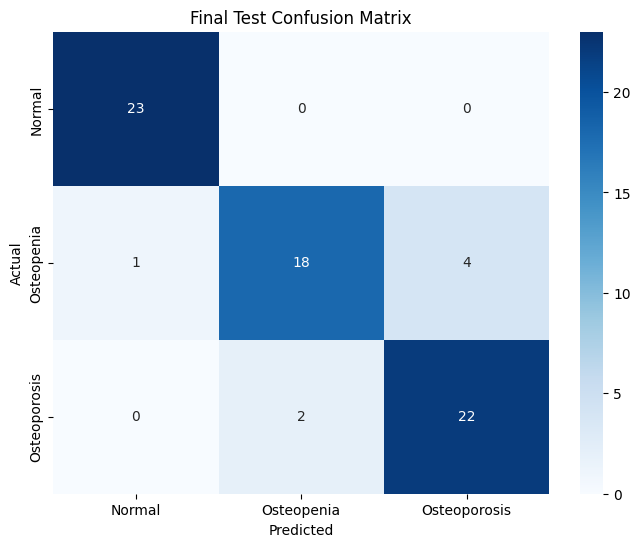


Per-class Performance:
Normal      : Recall=100.0%, Precision=95.8%
Osteopenia  : Recall=78.3%, Precision=90.0%
Osteoporosis: Recall=91.7%, Precision=84.6%


In [39]:

# Load best model and evaluate
best_model = OsteoporosisClassifier.load_from_checkpoint(
    checkpoint.best_model_path,
    num_classes=NUM_CLASSES,
    learning_rate=LEARNING_RATE
)

print("\nEvaluating final model...")
evaluate_model(trainer, best_model, datamodule)